<a href="https://colab.research.google.com/github/supertime1/BP_PPG/blob/master/BP_PPG_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook trains an simple PPG DNN by using labeled PPG data from Afib_Data_Clean notebook;
The loaded data is 30s segemented PPG signals with 125Hz sampling rate.

#2.Setup Environment



In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import os
import shutil
import glob
import wfdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import tensorflow_datasets as tfds
import multiprocessing
from datetime import datetime
import sklearn.metrics
import itertools
import io
import pickle
print(tf.__version__)

2.1.0


In [0]:
#run this cell to log device placement info
tf.debugging.set_log_device_placement(True)

In [0]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17489153691915448674
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6599774044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17826745072758545612
physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:02:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 6599774044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6881992550934106132
physical_device_desc: "device: 1, name: Quadro RTX 4000, pci bus id: 0000:05:00.0, compute capability: 7.5"
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 6599774044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4826959205987158995
physical_device_desc: "device: 2, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:GPU:3"
device_type: "GPU"
memory_limit: 6599774044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15876387964812918189
p

In [2]:
tf.test.is_built_with_cuda()

True

#3.Data Pipeline

## 3.1 Input Data

###3.1.1 Concatenate
Run the following code if data and label have not been concatenated

In [0]:
#concatenate data
def concatenate_data(directory):
  raw_signals_list = []
  files_list = directory + "filtered_PPG*.pkl"
  for name in glob.glob(files_list):
    raw_signal = pickle.load(open(name,'rb'))
    raw_signals_list.append(raw_signal)
  raw_signals = [y for x in raw_signals_list for y in x]
  return raw_signals

In [0]:
#load PPG signal
raw_signals = concatenate_data('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib PPG data/015ECG_015PPG_flatline/')

In [0]:
with open('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib PPG data/015ECG_015PPG_flatline/data', "wb") as fp:
  pickle.dump(raw_signals, fp)

In [0]:
#concatenate label
def concatenate_label(directory):
  raw_labels_list = []
  files_list = directory + "ECG_Afib_labels*.csv"
  for name in glob.glob(files_list):
    df = pd.read_csv(name,header=None)
    labels = df.to_numpy()
    raw_labels_list.append(labels.tolist())
    
  raw_labels = [y for x in raw_labels_list for y in x]
  return raw_labels

In [0]:
raw_labels = concatenate_label('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib PPG data/015ECG_015PPG_flatline/')

In [0]:
with open('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib PPG data/015ECG_015PPG_flatline/labels', "wb") as fp:
  pickle.dump(raw_labels, fp)

###3.1.2 Load data and label

In [0]:
with open('C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/BP_data.pkl', "rb") as fp:
  raw_signals = pickle.load(fp)

In [0]:
with open('C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/BP_label.pkl', "rb") as fp:
  raw_labels = pickle.load(fp)

In [5]:
#create the right dim for signals
raw_signals = np.array(raw_signals)
print('signals dim before resize',raw_signals.shape)
raw_signals = np.reshape(raw_signals,[len(raw_signals),10,750])
raw_signals = np.expand_dims(raw_signals, axis=3)
print('signals dim:', raw_signals.shape)

signals dim before resize (9102, 7500)
signals dim: (9102, 10, 750, 1)


In [6]:
raw_labels = np.array(raw_labels)
print('labels dim',raw_labels.shape)

labels dim (9102, 2)


###3.1.2 Generate train,val and test

In [0]:
#ratio value is between 0 and 1
#make sure seed is set to a same number for repeatable results\
#or to compare models apple to apple
def slice_dataset(dataset,labels,train_ratio,seed = 10):  
  DATASET_SIZE =len(list(dataset)) #only works in eager mode (e.g. TF version >= 2.0.x)
  train_size = int(train_ratio * DATASET_SIZE)
  val_size = DATASET_SIZE - train_size
  
  np.random.seed(seed=seed)
  np.random.shuffle(dataset)
  train_dataset = dataset[:train_size,:,:]
  val_dataset = dataset[-val_size:,:,:]

  np.random.seed(seed=seed)
  np.random.shuffle(labels)
  train_labels = labels[:train_size,:]
  val_labels = labels[-val_size:,:]

  return train_dataset,val_dataset,train_labels, val_labels

Generate train, val and test data and labels

In [8]:
train_dataset, test_dataset, train_labels, test_labels  = slice_dataset(raw_signals,raw_labels,0.95)
print("train_dataset dim", train_dataset.shape)
print("train_labels dim", train_labels.shape)
print("test_dataset dim", test_dataset.shape)
print("test_labels dim", test_labels.shape)

train_dataset dim (8646, 10, 750, 1)
train_labels dim (8646, 2)
test_dataset dim (456, 10, 750, 1)
test_labels dim (456, 2)


In [9]:
train_dataset, val_dataset, train_labels, val_labels  = slice_dataset(train_dataset,train_labels,0.9)
print("train_dataset dim", train_dataset.shape)
print("train_labels dim", train_labels.shape)
print("val_dataset dim", val_dataset.shape)
print("val_labels dim", val_labels.shape)

train_dataset dim (7781, 10, 750, 1)
train_labels dim (7781, 2)
val_dataset dim (865, 10, 750, 1)
val_labels dim (865, 2)


Check the distribution of systolic and diastolic BP value

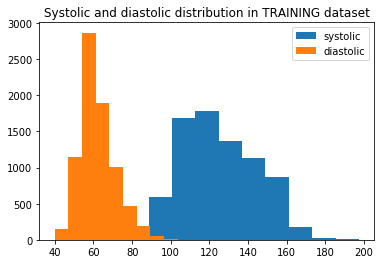

In [10]:
#check sys and dia distribution in train dataset
plt.title("Systolic and diastolic distribution in TRAINING dataset")
plt.hist(train_labels[:,0], label="systolic")
plt.hist(train_labels[:,1],label="diastolic")
plt.legend()

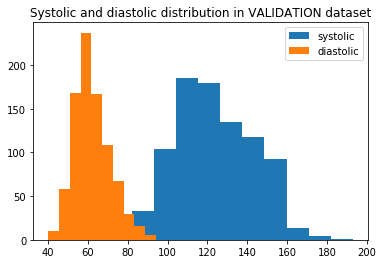

In [11]:
#check sys and dia distribution in validation dataset
plt.title("Systolic and diastolic distribution in VALIDATION dataset")
plt.hist(val_labels[:,0], label="systolic")
plt.hist(val_labels[:,1],label="diastolic")
plt.legend()

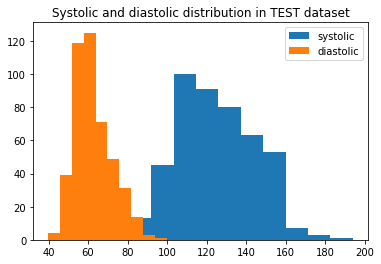

In [12]:
#check sys and dia distribution in test dataset
plt.title("Systolic and diastolic distribution in TEST dataset")
plt.hist(test_labels[:,0], label="systolic")
plt.hist(test_labels[:,1],label="diastolic")
plt.legend()

## 3.2 Extract, Transform and Load data

###3.2.1 Parallelize Extraction

In [0]:
#use interleave if more than one file are used
train = tf.data.Dataset.from_tensor_slices((train_dataset,train_labels)) 

In [0]:
validation = tf.data.Dataset.from_tensor_slices((val_dataset,val_labels))

### 3.2.2 Parallelize Transformation


In [0]:
#don't need to run this cell, just as a placeholder
cores = multiprocessing.cpu_count()
print(cores)
#dataset = dataset.map(function, num_parallel_calls = cores)

12


### 3.2.3 Parallelize Loading

In [0]:
batch_size = 32
train_dataset = train.cache()
train_dataset = train_dataset.shuffle(len(list(train))).repeat().batch(batch_size,drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
val_dataset = validation.repeat().batch(batch_size, drop_remainder=True)

#4.Train Model

##4.1 CNN + LSTM

In [33]:
from tensorflow.keras.layers import BatchNormalization
BatchNormalization._USE_V2_BEHAVIOR = False
#create CNN layers
cnn = tf.keras.Sequential([
    #1st Conv1D
    tf.keras.layers.Conv1D(8, 1, strides=1, 
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2,strides=2),
    tf.keras.layers.Dropout(0.2),
    #2nd Conv1D
    tf.keras.layers.Conv1D(16, 3, strides=1,
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2,strides=2),
    tf.keras.layers.Dropout(0.2),
    #3rd Conv1D
    tf.keras.layers.Conv1D(32, 3, strides=1,
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2,strides=2),
    tf.keras.layers.Dropout(0.2),
    #4th Conv1D
    tf.keras.layers.Conv1D(64, 3, strides=1,
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2,strides=2),
    tf.keras.layers.Dropout(0.2),
    #5th Conv1D
    tf.keras.layers.Conv1D(16, 1, strides=1,
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #Full connection layer
    tf.keras.layers.Flatten()
])

#combine with LSTM
model = tf.keras.Sequential([
        tf.keras.layers.TimeDistributed(cnn,input_shape=(10,750,1)),                   
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 720)           9776      
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 64)            192768    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 212,978
Trainable params: 212,706
Non-trainable params: 272
_________________________________________________________________


##4.2 Define callbacks

###4.2.1 Learning rate scheduler

In [0]:
def decay(epoch):
  if epoch < 50:
    return 1e-3
  elif epoch >= 50 and epoch < 200:
    return 1e-4
  else:
    return 1e-5

In [0]:
#callback: schedule a learning rate incline iteration
lr_schedule = tf.keras.callbacks.LearningRateScheduler(decay)

###4.2.2 Tensorboard

In [0]:
#callback: tensorboard
log_dir=r"C:\Users\57lzhang.US04WW4008\Desktop\Blood pressure\BP data\logs\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S") +"CNN+LSTM"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

###4.2.4 Checkpoint

In [0]:
#callback: checkpoint
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Blood pressure\BP data\models\CNN+LSTM-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

##4.3 Train the model 

### 4.3.1 Start Training

In [38]:
#clear history if necessary
tf.keras.backend.clear_session()
#strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()) ##to overwrite NCCL cross device communication as this is running in Windows
#with strategy.scope():

model = model

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='mse', 
              metrics=['mae'])

callbacks_list = [tensorboard_callback, checkpoint, lr_schedule]

#start training
model.fit(train_dataset,
          epochs=300,
          steps_per_epoch = len(list(train))/batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps = len(list(validation))/batch_size,
          callbacks=callbacks_list
          )

Train for 243.15625 steps, validate for 27.03125 steps
Epoch 1/300
243/243 [============================>.] - ETA: 0s - loss: 8371.9828 - mae: 85.1020
Epoch 00001: loss improved from inf to 8367.41581, saving model to C:\Users\57lzhang.US04WW4008\Desktop\Blood pressure\BP data\models\CNN+LSTM-01-8367.4158.hdf5
244/243 [==============================] - 23s 93ms/step - loss: 8367.4158 - mae: 85.0785 - val_loss: 7659.1064 - val_mae: 79.5240
Epoch 2/300
243/243 [============================>.] - ETA: 0s - loss: 6841.6644 - mae: 75.7857
Epoch 00002: loss improved from 8367.41581 to 6838.55112, saving model to C:\Users\57lzhang.US04WW4008\Desktop\Blood pressure\BP data\models\CNN+LSTM-02-6838.5511.hdf5
244/243 [==============================] - 17s 69ms/step - loss: 6838.5511 - mae: 75.7664 - val_loss: 6409.1527 - val_mae: 71.6227
Epoch 3/300
243/243 [============================>.] - ETA: 0s - loss: 5740.1992 - mae: 68.2593
Epoch 00003: loss improved from 6838.55112 to 5736.30189, saving m

## 4.4 Save Model for future evaluation

In [0]:
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data")
model.save('Deep_PPG_CNN_041120.h5')
print("Save model to disk")

Save model to disk


# 5.Model Evaluation

## 5.1 Load saved model

In [0]:
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Blood pressure\BP data\models")
model = tf.keras.models.load_model('CNN+LSTM-285-10.2110.hdf5')

## 5.2 MAE

In [0]:
bp_estimate=model.predict(test_dataset)

In [42]:
from sklearn.metrics import mean_absolute_error
sys_mae = mean_absolute_error(test_labels[:,0], bp_estimate[:,0])
dia_mae = mean_absolute_error(test_labels[:,1], bp_estimate[:,1])
print("Systolic MAE in test dataset:", round(sys_mae,1))
print("Diastolic MAE in test dataset:", round(dia_mae,1))

Systolic MAE in test dataset: 11.2
Diastolic MAE in test dataset: 6.2
